In [25]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from IPython.display import Image,display
from langchain_openai import ChatOpenAI
from typing import TypedDict,Annotated

import gradio as gr
from dotenv import load_dotenv
import os,requests




In [26]:
load_dotenv(override=True)

True

In [27]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper =GoogleSerperAPIWrapper()
serper.run("capital of germany?")

"The capital of Germany is the city of Berlin. [1] It is the seat of the Federal President of Germany, whose official residence is Bellevue Castle. Berlin is the capital of Germany, the seat of its federal parliament and government, and its role is enshrined in the Basic Law. Berlin is the capital and chief urban center of Germany. Berlin was the capital of Prussia and then, from 1871, of a unified Germany. Though ... Berlin is the capital and largest city of Germany, by both area and population. With 3.7 million inhabitants, it has the highest population within its city ... Berlin, the capital city of Germany, is renowned for its exceptional range of landmarks, vibrant cultural scene and way of life that's somehow all go yet ... Because Berlin has been historically the capital of Germany since 1701 (first Prussia after that German Reich). Berlin - Official Website of the City of Berlin, Capital of Germany – Berlin.de. Overview of the decision to make Berlin—rather than Bonn—the capita

In [28]:
from langchain.agents import Tool #langchain also provides some wrapper code

tool_search =Tool(
    name="search",
    func=serper.run,
    description="Useful for when we need more information from an online Search"
)

In [29]:
tool_search.invoke("what is ai?")

"AI is technology that enables computers and machines to simulate human learning, comprehension, problem solving, decision making, creativity and autonomy. Artificial intelligence refers to computer systems that can perform complex tasks normally done by human-reasoning, decision making, ... Artificial intelligence (AI) encompasses the fields of computer and data science focused on building machines with human intelligence. Artificial intelligence is a technology that allows you to generate, classify, and perform tasks like image analysis and speech recognition. Artificial Intelligence (AI) is a transformative technology that enables machines to perform human-like problem-solving tasks. From recognizing images and ... Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence This content isn't available. Artificial Intelligence, or AI, means teaching computers to think, act, or make decisions in ways that feel 

Pushover Token Tool


In [30]:
pushover_user =os.getenv('PUSHOVER_USER')
pushover_api=os.getenv('PUSHOVER_API') #token is api
pushover_base_url='https://api.pushover.net/1/messages.json'

def push(text:str):
    """Sends a Push Notification to the User"""
    response=requests.post(pushover_base_url,data={"token":pushover_api,"user":pushover_user,"message":text})
    print(response.status_code,response.text)

In [31]:
tool_push =Tool(
    name="Send_Push_Notification",
    func=push,
    description="Useful when we want to send push Notifications"
)

In [32]:
tool_push.invoke("Hello pushover app")

200 {"status":1,"request":"944a8c96-6c7b-4ebf-8fae-ad38377999c7"}


In [33]:
tools=[tool_search,tool_push]

In [34]:
llm =ChatOpenAI(model="gpt-4o-mini")
llm_with_tools=llm.bind_tools(tools=tools)

In [ ]:
llm.invoke("tell me latest news in india and what date is today?")

AIMessage(content="I don't have access to real-time news updates or the current date beyond my last training cutoff in October 2023. However, you can easily check the latest news in India by visiting reputable news websites or using news apps. If you're looking for specific topics or summaries related to events that occurred before October 2023, feel free to ask!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 19, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CSU6jjKofiW7xBWLzE3ldtky1pSoh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8cb14ea2-1397-45bb-8aff-c948724d3060-0', usage_metadata={'input_tokens': 19, 'out

: 

In [35]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [36]:
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

In [37]:
graph_builder=StateGraph(State)

In [38]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_node("tools",ToolNode(tools=tools))

In [39]:
graph_builder.add_conditional_edges("chatbot",tools_condition,"tools")
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START,"chatbot")

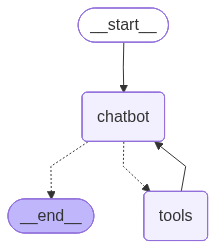

In [40]:
graph=graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def chat(user_input:str,history):
    result=graph.invoke({"messages":[{"role":"user","content":user_input}]})
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(chat,type="messages").launch()


* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='6a58884a-f3b5-4447-a07d-99f26e5db2f4'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 89, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CSTvV6omg2V4ZRIM5BIAxFTTpyjKt', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--10bcdf9c-4388-45c7-b957-965359f48f74-0', usage_metadata={'input_tokens': 89, 'output_tokens': 10, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
200 {"status":1,"request":"8ae9f0af

In [ ]:
from langgraph.checkpoint.memory import MemorySaver